# Import Libraries

In [1]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Reading Input files

In [2]:
Final_Dataset_Provider_Train = pd.read_csv('Final_Train.csv')
Final_Dataset_Provider_Test = pd.read_csv('Final_Test.csv')

In [3]:
Final_Dataset_Provider_Test.drop(['Unnamed: 0'],axis=1,inplace=True)
Final_Dataset_Provider_Train.drop(['Unnamed: 0'],axis=1,inplace=True)

In [4]:
Final_Dataset_Provider_Train.shape

(5410, 247)

# Separate independent and dependent variables and standardizing data

In [5]:
# Seperate dependent and independent variables
x_train = Final_Dataset_Provider_Train.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Train['PotentialFraud']
x_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

In [6]:
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_train_std = standard_scaler.transform(x_train)
x_test_std = standard_scaler.transform(x_test)

# Splitting the data into train and test for model building and predicted 
# results validation


In [7]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train_std, y_train, test_size=0.3,random_state=42,stratify=y_train)


In [8]:
x_tr.shape, x_val.shape, y_tr.shape, y_val.shape

((3787, 245), (1623, 245), (3787,), (1623,))

In [9]:
counter = Counter(y_tr)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 9.35% and Non-Fraud Percentage = 90.65%


# Oversample the data using SMOTE to make it 20:80 ratio

In [10]:
oversample = SMOTE(sampling_strategy=0.25)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 20.00% and Non-Fraud Percentage = 80.00%


# Logistic Regression Model

In [11]:
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}
logreg = LogisticRegression(max_iter=1000)
logreg_cv = GridSearchCV(logreg, grid, cv=3, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_os, y_tr_os)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l2']},
             return_train_score=True, scoring='roc_auc')

In [12]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 1.0, 'penalty': 'l2'}
roc_auc_score : 0.9421626301752726


In [13]:
log_reg = LogisticRegression(C=0.1, penalty='l2',max_iter=1000)
log_reg.fit(x_tr_os, y_tr_os)

LogisticRegression(C=0.1, max_iter=1000)

# Functions for creating ROC, AUC and Confusion Matrix

In [18]:
def pred_prob(clf, data): 
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(visible=False, which='major', color='g', linestyle='-')
    plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
#     print("max(tpr*(1-fpr)) = ", max(tpr*(1-fpr)), "for threshold = ", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [28]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    # Confusion matrix for train and test dataset
    fig, ax = plt.subplots(1,2,figsize=(12,4),sharex=True, sharey=True)

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    print(cm)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    
    ax[0].set_title('Train Dataset Confusion Matrix', size = 10)
    ax[0].set_xlabel("Predicted Label", size = 10)
    ax[0].set_ylabel("Actual Label", size = 10)
    
    
    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm1 = confusion_matrix(y_test, test_prediction)
    print(cm1)
    sns.heatmap(cm1, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Dataset Confusion Matrix', size = 10)
    ax[1].set_xlabel("Predicted Label", size = 10)
    ax[1].set_ylabel("Actual Label", size = 10)
    
    #plt.grid(visible=False)
    #plt.show()
        
    return train_prediction, test_prediction

In [29]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)
    
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
#     print(len(test_prediction))
    
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, test_f1_score, best_t

Train AUC =  0.9442453846764945
Test AUC =  0.9454005510036138


C:\Users\KuldeepJolly\AppData\Local\Temp\ipykernel_2920\401089826.py:16: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(visible=False, which='major', color='g', linestyle='-')


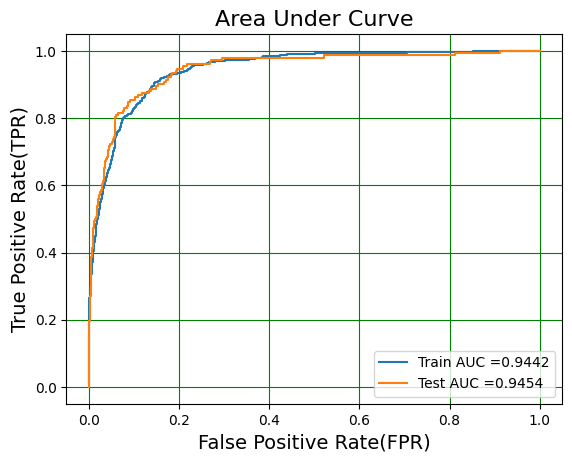

[[2935  498]
 [  82  776]]
[[1268  203]
 [  17  135]]
Best Threshold = 0.1219
Model AUC is : 0.9454
Model F1 Score is : 0.5510


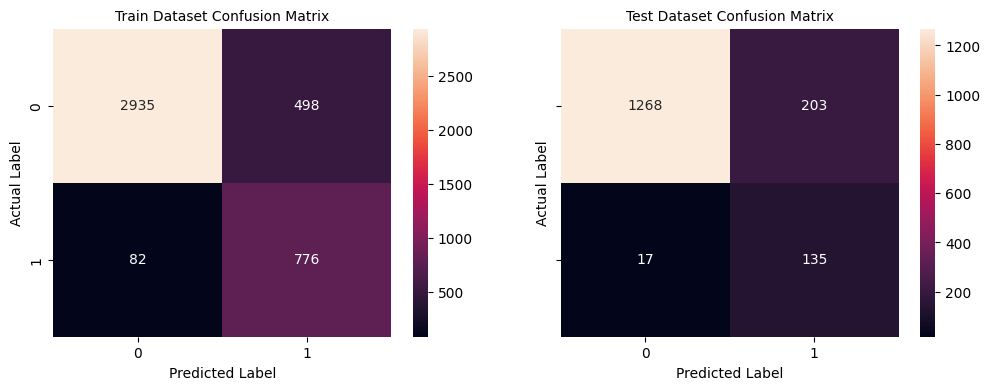

In [30]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

# Decision Tree model

In [31]:
decisiontree = DecisionTreeClassifier() #class_weight = 'balanced'

parameters = {'criterion':['gini','entropy'], 'max_depth': [5, 10, 50, 100, 150, 200, 250, 500], 'min_samples_split': [5, 10, 50, 100, 150, 200, 250, 500]}

decisiontree_cv = GridSearchCV(decisiontree, parameters, cv=3, scoring='roc_auc', n_jobs=-1, return_train_score=True)
decisiontree_cv.fit(x_tr_os, y_tr_os)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 50, 100, 150, 200, 250, 500],
                         'min_samples_split': [5, 10, 50, 100, 150, 200, 250,
                                               500]},
             return_train_score=True, scoring='roc_auc')

In [32]:
print("best parameters = ",decisiontree_cv.best_params_)
print("roc_auc_score :",decisiontree_cv.best_score_)

best parameters =  {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 250}
roc_auc_score : 0.9388534977100341


In [33]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9571769137746418
Test AUC =  0.9306482342838742


C:\Users\KuldeepJolly\AppData\Local\Temp\ipykernel_2920\401089826.py:16: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(visible=False, which='major', color='g', linestyle='-')


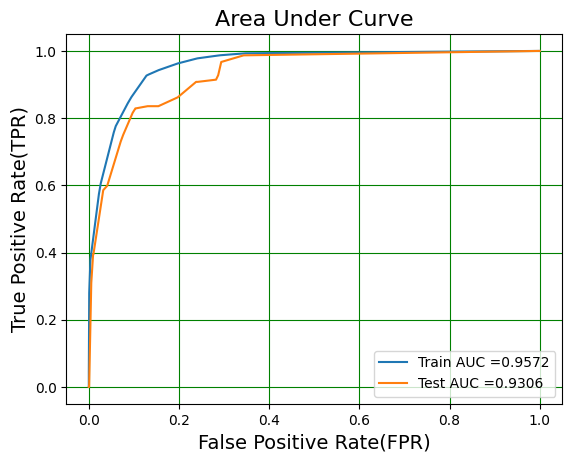

[[2994  439]
 [  63  795]]
[[1279  192]
 [  25  127]]
Best Threshold = 0.3234
Model AUC is : 0.9306
Model F1 Score is : 0.5393


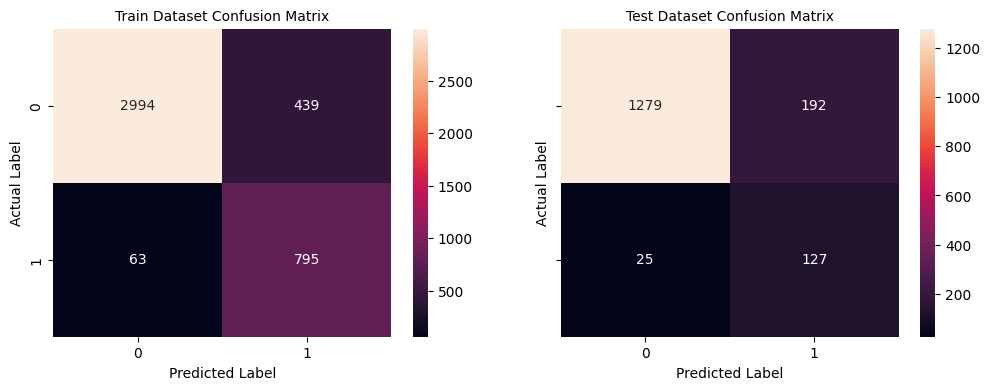

In [34]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

#  Support Vector Classifier Model

In [35]:
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_os, y_tr_os)

C:\Users\KuldeepJolly\insfraudnew\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\KuldeepJolly\insfraudnew\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\KuldeepJolly\insfraudnew\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\KuldeepJolly\insfraudnew\Lib\site-packages\sklearn\svm\_classes.py", line 3

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [36]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5, 'penalty': 'l2'}
roc_auc_score : 0.9402788705215703


In [37]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=1.0, penalty='l2',max_iter=1000)
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

C:\Users\KuldeepJolly\insfraudnew\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\KuldeepJolly\insfraudnew\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\KuldeepJolly\insfraudnew\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\KuldeepJolly\insfraudnew\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\KuldeepJolly\insfraudnew\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to 

CalibratedClassifierCV(estimator=LinearSVC())

Train AUC =  0.9521893292647736
Test AUC =  0.937900282657698


C:\Users\KuldeepJolly\AppData\Local\Temp\ipykernel_2920\401089826.py:16: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(visible=False, which='major', color='g', linestyle='-')


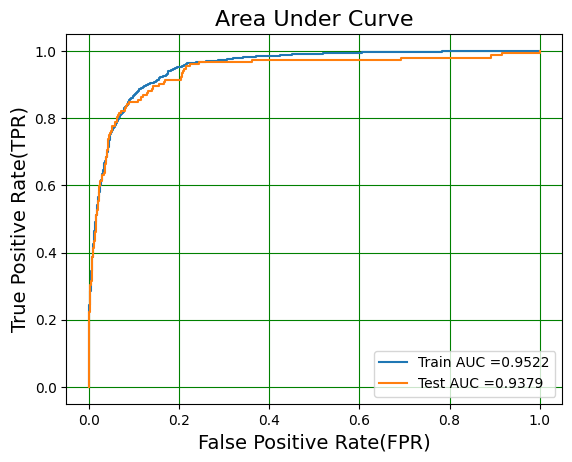

[[3054  379]
 [  98  760]]
[[1306  165]
 [  22  130]]
Best Threshold = 0.1614
Model AUC is : 0.9379
Model F1 Score is : 0.5817


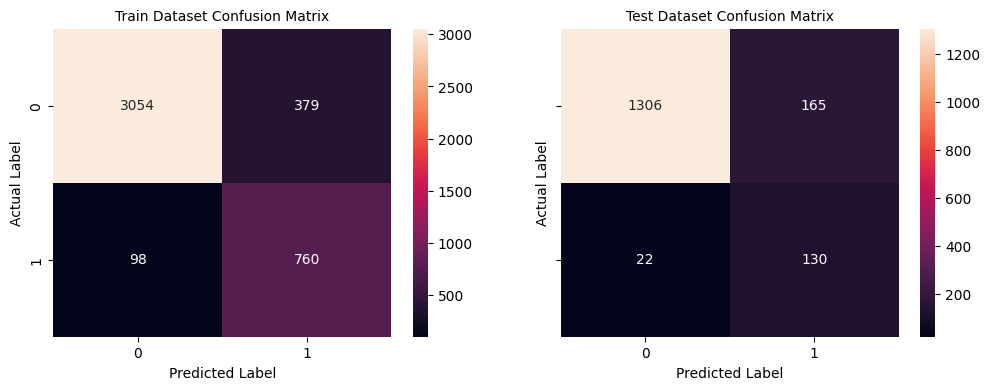

In [38]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

# Gaussian Naive Bayes Classifier Model

In [39]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8501429631636447
Test AUC =  0.8804563669540949


C:\Users\KuldeepJolly\AppData\Local\Temp\ipykernel_2920\401089826.py:16: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(visible=False, which='major', color='g', linestyle='-')


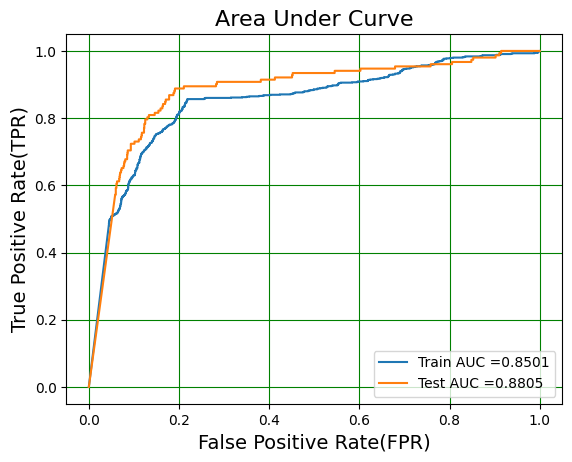

[[2682  751]
 [ 123  735]]
[[1158  313]
 [  16  136]]
Best Threshold = 0.0000
Model AUC is : 0.8805
Model F1 Score is : 0.4526


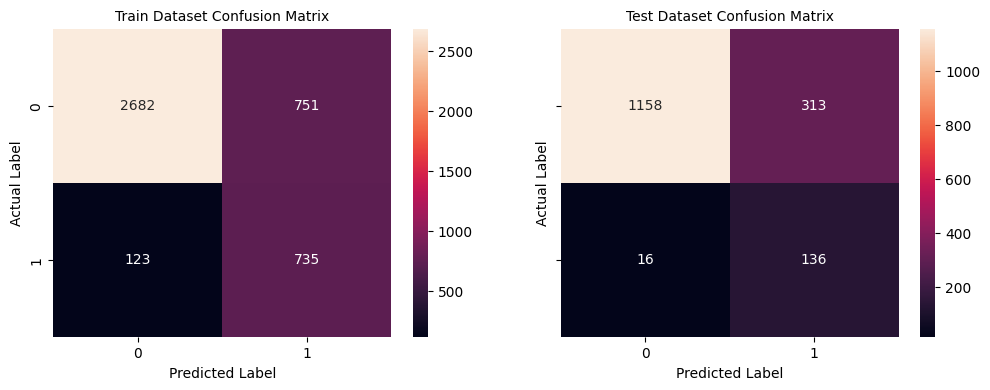

In [40]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [41]:
from beautifultable import BeautifulTable
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.95", "0.55"])
table.append_row(["Decision Tree", "0.93", "0.55"])
table.append_row(["Support Vector Classifier", "0.94", "0.55"])
table.append_row(["Naive Bayes", "0.88", "0.46"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.95 |   0.55   |
+---------------------------+------+----------+
|       Decision Tree       | 0.93 |   0.55   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.94 |   0.55   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.46   |
+---------------------------+------+----------+


C:\Users\KuldeepJolly\insfraudnew\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
C:\Users\KuldeepJolly\insfraudnew\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


# Dumping model file and using that file for the prediction

In [42]:
pickle.dump(log_reg, open('model.pkl','wb'))

In [43]:
model = pickle.load( open('model.pkl','rb'))

In [44]:
y_predict = model.predict(x_val)

In [53]:
type(y_predict)

numpy.ndarray

# Fraud percentage in the model prediciton

In [62]:
import numpy as np
unique,counts=np.unique(y_predict,return_counts=True)
a=dict(zip(unique,counts))

In [63]:
fraud = (a[1]/(a[0]+a[1]))*100

In [65]:
print('Fraud percentage', round(fraud,2))

Fraud percentage 9.43
